# RuCl Full Scale Example
We can now implement a full scale example, with details described here https://www.nature.com/articles/s41535-019-0203-y

In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openfermion
from openfermion import QubitOperator, count_qubits
from openfermion.circuits import trotter_steps_required, error_bound
from openfermion.circuits.trotter_exp_to_qgates import trotterize_exp_qubop_to_qasm

import networkx as nx
from networkx.generators.lattice import hexagonal_lattice_graph
from networkx.classes.graph import Graph

import cirq
from cirq.contrib import qasm_import

import pyLIQTR
from pyLIQTR.circuits.qsp import generate_QSP_circuit
from pyLIQTR.utils.Hamiltonian import Hamiltonian as pyH
from pyLIQTR.utils.utils import open_fermion_to_qasm, count_T_gates
from pyLIQTR.utils.qsp_helpers import circuit_decompose_once, circuit_decompose_once, print_to_openqasm
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform
from pyLIQTR.phase_factors.fourier_response.fourier_response import Angler_fourier_response

In [3]:
#Helper Functions
t_init = time.perf_counter()
def get_T_depth_wire(cpt_circuit):
    #maximum number of T-gates on a wire.  This may be more optimistic than
    #number of layers with T-gates.  Perhaps good to treat as lower bound
    #for an implementation
    count_dict = dict()
    for moment in cpt_circuit:
        for operator in moment:
            opstr = str(operator)
            if opstr[0] == 'T':
                reg_label = opstr[opstr.find("(")+1:opstr.find(")")]
                if not reg_label in count_dict:
                    count_dict[reg_label] = 1
                else:
                    count_dict[reg_label] += 1
    max_depth=0
    for register in count_dict:
        if count_dict[register] > max_depth:
            max_depth = count_dict[register]
    return max_depth

def get_T_depth(cpt_circuit):
    t_depth = 0
    for moment in cpt_circuit:
        for operator in moment:
            opstr = str(operator)
            if opstr[0] == 'T':
                t_depth += 1
                break
    return t_depth

def plot_T_step_histogram(cpt_circuit, lowest_ind=0, **kwargs):
    t_widths = [0] * len(cpt_circuit)
    for i, moment in enumerate(cpt_circuit):
        width = 0
        for operator in moment:
            opstr = str(operator)
            if opstr[0] == 'T':
                width += 1
        t_widths[i] = width
    bins = range(max(t_widths))
    histogram = plt.hist(t_widths, bins[lowest_ind:-1], **kwargs)
    return histogram
    
def count_gates(cpt_circuit):
    count = 0
    for moment in cpt_circuit:
            count += len(moment)
    return count

def pyliqtr_hamiltonian_to_openfermion_qubit_operator(H):
    open_fermion_operator = QubitOperator()
    for term in H.terms:
        open_fermion_term = ''
        for i, pauli in enumerate(term[0]):
            if pauli != 'I':
                open_fermion_term = f'{open_fermion_term}{pauli}{i} '
        open_fermion_term_op = QubitOperator(open_fermion_term)
        if open_fermion_term:
            open_fermion_operator += term[1] * open_fermion_term_op
    return open_fermion_operator

def flatten_nx_graph(graph: Graph) -> Graph:
    new_ids = {}
    count = 0
    for node in graph.nodes:
        if node not in new_ids:
            new_ids[node] = count
            count = count + 1
    new_g = nx.relabel_nodes(graph, new_ids)
    return new_g

In [4]:
def estimate_qsp(pyliqtr_hamiltonian, timesteps, energy_precision, outdir, hamiltonian_name="hamiltonian", write_circuits=False):
    timestep_of_interest=1 #for magnus like argument
    t0 = time.perf_counter()
    
    angles_response = Angler_fourier_response(tau=timestep_of_interest*pyliqtr_hamiltonian.alpha, eps=energy_precision, random=True, silent=True)
    angles_response.generate()
    angles = angles_response.phases

    qsp_circuit = generate_QSP_circuit(pyliqtr_hamiltonian, angles, pyliqtr_hamiltonian.problem_size)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to generate high level QSP circuit: " + str(elapsed) + " seconds")
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    subcircuit_counts = dict()
    t_counts = dict()
    t_depths = dict()
    t_depth_wires = dict()
    clifford_counts = dict()
    gate_counts = dict()
    subcircuit_depths = dict()
    
    outfile_qasm_high_level = outdir + hamiltonian_name + "_high_level.qasm"
    outfile_data = outdir + hamiltonian_name + "_high_level.dat"
    
    for moment in qsp_circuit:
        for operation in moment:
            gate_type = type(operation.gate)
            if gate_type in subcircuit_counts:
                subcircuit_counts[gate_type] += 1
            
            else:
                outfile_qasm_decomposed = outdir+str(gate_type)[8:-2]+".decomposed.qasm"
                outfile_qasm_cpt = outdir+str(gate_type)[8:-2]+".cpt.qasm"
                
                t0 = time.perf_counter()
                decomposed_circuit = circuit_decompose_once(circuit_decompose_once(cirq.Circuit(operation)))
                t1 = time.perf_counter()
                elapsed = t1 - t0
                print("    Time to decompose high level " + str(gate_type)[8:-2] +" circuit: " + str(elapsed) + " seconds")
                
                t0 = time.perf_counter()
                cpt_circuit = clifford_plus_t_direct_transform(decomposed_circuit)
                t1 = time.perf_counter()
                elapsed = t1 - t0
                print("    Time to transform decomposed " + str(gate_type)[8:-2] + " circuit to Clifford+T: " + str(elapsed) + " seconds")
                
                if write_circuits:
                    with open(outfile_qasm_decomposed, 'w') as f:
                        print_to_openqasm(f, decomposed_circuit, qubits=decomposed_circuit.all_qubits())
                    
                    with open(outfile_qasm_cpt, 'w') as f:
                        print_to_openqasm(f, cpt_circuit, qubits=cpt_circuit.all_qubits())
                
                subcircuit_counts[gate_type] = 1
                subcircuit_depths[gate_type] = len(cpt_circuit)
                t_counts[gate_type] = count_T_gates(cpt_circuit)
                gate_counts[gate_type] = count_gates(cpt_circuit)
                t_depths[gate_type] = get_T_depth(cpt_circuit)
                t_depth_wires[gate_type] = get_T_depth_wire(cpt_circuit)
                clifford_counts[gate_type] = gate_counts[gate_type] - t_counts[gate_type]
                
    total_gate_count = 0
    total_gate_depth = 0
    total_T_depth = 0
    total_T_depth_wire = 0
    total_T_count = 0
    total_clifford_count = 0
    for gate in subcircuit_counts:
        total_gate_count += subcircuit_counts[gate] * gate_counts[gate] * timesteps / timestep_of_interest
        total_gate_depth += subcircuit_counts[gate] * subcircuit_depths[gate] * timesteps / timestep_of_interest
        total_T_depth += subcircuit_counts[gate] * t_depths[gate] * timesteps / timestep_of_interest
        total_T_depth_wire += subcircuit_counts[gate] * t_depth_wires[gate] * timesteps / timestep_of_interest
        total_T_count += subcircuit_counts[gate] * t_counts[gate] * timesteps / timestep_of_interest
        total_clifford_count += subcircuit_counts[gate] * clifford_counts[gate] * timesteps / timestep_of_interest
    with open(outfile_data, 'w') as f:
        total_gate_count 
        f.write(str("Logical Qubit Count:"+str(len(qsp_circuit.all_qubits()))+"\n"))
        f.write(str("Total Gate Count:"+str(total_gate_count)+"\n"))
        f.write(str("Total Gate Depth:"+str(total_gate_depth)+"\n"))
        f.write(str("Total T Count:"+str(total_T_count)+"\n"))
        f.write(str("Total T Depth:"+str(total_T_depth)+"\n"))
        f.write(str("Maximum T Count on Single Wire:"+str(total_T_depth_wire)+"\n"))
        f.write(str("Total Clifford Count:"+str(total_clifford_count)+"\n"))
        f.write("Subcircuit Info:\n")
        for gate in subcircuit_counts:
            f.write(str(str(gate)+"\n"))
            f.write(str("Subcircuit Occurrences:"+str(subcircuit_counts[gate]*timesteps)+"\n"))
            f.write(str("Gate Count:"+str(gate_counts[gate])+"\n"))
            f.write(str("Gate Depth:"+str(subcircuit_depths[gate])+"\n"))
            f.write(str("T Count:"+str(t_counts[gate])+"\n"))
            f.write(str("T Depth:"+str(t_depths[gate])+"\n"))
            f.write(str("Maximum T Count on a Single Wire:"+str(t_depth_wires[gate])+"\n"))
            f.write(str("Clifford Count:"+str(clifford_counts[gate])+"\n"))
    return qsp_circuit


def find_hamiltonian_ordering(of_hamiltonian):
    """
    Function to generate a near optimal term ordering for trotterization of transverse field Ising Models.
    This would need to be modified if there were multi-qubit interactions that were not just ZZ
    """
    #ordering hamiltonian terms by performing edge coloring to make optimal trotter ordering
    #assuming that any 2 body interactions are ZZ
    sorted_terms = sorted(list(of_hamiltonian.terms.keys()))
    sorted_terms.sort(key=lambda x: len(x) * 100 + ord(x[0][1])) #Z and X get translated to 90 and 88 respectively, multiplying by 100 ensures interacting term weight is considered
    one_body_terms_ordered = list(filter(lambda x: len(x) == 1, sorted_terms))
    two_body_terms = list(filter(lambda x: len(x) == 2, sorted_terms))
    
    #assigning edge colorings to order two body terms
    g = nx.Graph()
    for term in two_body_terms:
        edge = (term[0][0], term[1][0])
        g.add_edge(*edge)
    edge_coloring = nx.greedy_color(nx.line_graph(g))
    nx.set_edge_attributes(g, edge_coloring, "color")
    colors = list()
    for (i,term) in enumerate(two_body_terms):
        n1,n2 = (term[0][0], term[1][0])
        color = g.edges[n1,n2]['color']
        term = (*term, color)
        two_body_terms[i] = term
    
    two_body_terms.sort(key=lambda x: x[2])
    two_body_terms_ordered = list()
    for (i,term) in enumerate(two_body_terms):
        new_item = (term[0],term[1])
        two_body_terms_ordered.append((term[0], term[1]))
    return one_body_terms_ordered + two_body_terms_ordered

def estimate_trotter(openfermion_hamiltonian,timesteps, energy_precision, outdir, hamiltonian_name="hamiltonian", write_circuits=False):
    t0 = time.perf_counter()
    bounded_error = error_bound(list(openfermion_hamiltonian.get_operators()),tight=False)
    nsteps = trotter_steps_required(trotter_error_bound = bounded_error,
                                                time = timesteps, 
                                                energy_precision = energy_precision)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to estimate Number of steps required: " + str(elapsed) + " seconds")
    
    t0 = time.perf_counter()
    term_ordering = find_hamiltonian_ordering(openfermion_hamiltonian)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to find term ordering: " + str(elapsed) + " seconds")
    
    t0 = time.perf_counter()
    trotter_circuit_of = trotterize_exp_qubop_to_qasm(openfermion_hamiltonian, trotter_order=2, evolution_time=timesteps/nsteps, term_ordering=term_ordering)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to generate trotter circuit from openfermion: " + str(elapsed) + " seconds")
    
    qasm_str_trotter = open_fermion_to_qasm(count_qubits(openfermion_hamiltonian), trotter_circuit_of)
    trotter_circuit_qasm = qasm_import.circuit_from_qasm(qasm_str_trotter)
    
    t0 = time.perf_counter()
    cpt_trotter = clifford_plus_t_direct_transform(trotter_circuit_qasm)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to decompose trotter to Clifford + T: " + str(elapsed) + " seconds")
    
    #writing the the higher level trotter circuit to a file as well as the clifford + T circuit
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    if write_circuits:
        outfile_qasm_decomposed = outdir + "trotter_circuit_" + hamiltonian_name + ".qasm" 
        outfile_qasm_cpt = outdir + "trotter_cpt_" + hamiltonian_name + ".qasm"
        with open(outfile_qasm_decomposed, 'w') as f:
            print_to_openqasm(f, trotter_circuit_qasm, qubits=trotter_circuit_qasm.all_qubits())
        with open(outfile_qasm_cpt, 'w') as f:
            print_to_openqasm(f, cpt_trotter, qubits=cpt_trotter.all_qubits())
    
    t0 = time.perf_counter()
    outfile_data = outdir + "trotter_" + hamiltonian_name + ".dat"
    gate_count = count_gates(cpt_trotter)
    t_count = count_T_gates(cpt_trotter)
    t_depth = get_T_depth(cpt_trotter)
    t_depth_wire = get_T_depth_wire(cpt_trotter)
    with open(outfile_data, 'w') as f:
        f.write("Logical Qubit Count:"+str(len(cpt_trotter.all_qubits()))+"\n")
        f.write("Number of Trotter Steps Required (Loose Upper Bound):"+ str(nsteps) +"\n")
        f.write("Total T Depth:"+str(t_depth * nsteps)+"\n")
        f.write("Maximum T Count on a Single Wire:"+str(t_depth_wire * nsteps)+"\n")
        f.write("Single Step Gate Count:"+str(gate_count)+"\n")
        f.write("Single Step Gate Depth:"+str(len(cpt_trotter))+"\n")
        f.write("Single Step T Count:"+str(t_count)+"\n")
        f.write("Single Step T Depth:"+str(t_depth)+"\n")
        f.write("Single Step Maximum T Count on a Single Wire:"+str(t_depth_wire)+"\n")
        f.write("Single Step Clifford Count:"+str(gate_count - t_count)+"\n")
    
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("  Time to enumerate resource estimates: " + str(elapsed) + " seconds")
    
    return cpt_trotter

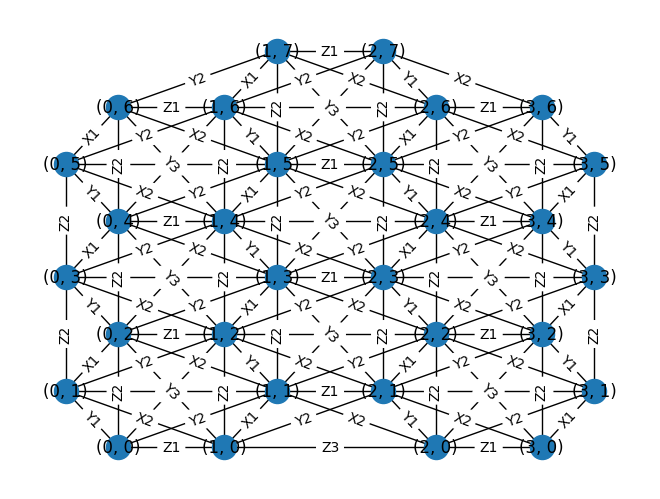

In [5]:
def assign_hexagon_labels_rucl(g):
    for n1, n2 in g.edges:
        #start by making sure that the edges are ordered correctly
        r1,c1 = n1
        r2,c2 = n2
        if r2 - r1 < 0 or c2 - c1 < 0:
            swap_r2 = r1
            swap_c2 = c1
            r1 = r2
            c1 = c2
            r2 = swap_r2
            c2 = swap_c2
        
        #now that they are ordered correctly, we can assign labels
        label = ''
        if c1 == c2:
            label = 'Z1'
        elif (((r1 % 2) + (c1 % 2)) % 2 == 0):#apparently you can differentiate X and Y labels based off nx's node label parity.  Huh.
            label = 'Y1'
        else:
            label = 'X1'
        
        g[n1][n2]['label'] = label
       
    #Adding next nearest and next-next nearest neighbor edges and labels
    for n in g.nodes:
        r,c = n
        
        #next nearest neighbors
        if (r, c+2) in g:
            g.add_edge(n, (r, c+2), label = 'Z2')
        if (r+1, c+1) in g:
            g.add_edge(n, (r+1, c+1), label = "Y2")
        if (r-1, c+1) in g:
            g.add_edge(n, (r-1, c+1), label = "X2")
       
        #next-next nearest neighbors
        if (r+1, c) in g and not ((n, (r+1, c)) in g.edges):
            g.add_edge(n, (r+1,c), label = "Z3")
        if (r+1, c+2) in g and (r + c)%2 == 0:
            g.add_edge(n, (r+1, c+2), label="X3")
        if (r-1, c+2) in g and (r + c)%2 == 1:
            g.add_edge(n, (r-1, c+2), label="Y3")

g_rucl = hexagonal_lattice_graph(3,3)
pos = nx.get_node_attributes(g_rucl, 'pos')
assign_hexagon_labels_rucl(g_rucl)
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in g_rucl.edges(data=True)]);
nx.draw(g_rucl, pos, with_labels=True)
nx.draw_networkx_edge_labels(g_rucl, pos,edge_labels = edge_labels);

In [6]:
rucl_references = ["Winter et al. PRB", "Winter et al. NC", "Wu et al.", "Cookmeyer and Moore", "Kim and Kee", "Suzuki and Suga", 
              "Yadav et al.", "Ran et al.", "Hou et al.", "Wang et al.", "Eichstaedt et al.", "Eichstaedt et al.", 
              "Eichstaedt et al.", "Banerjee et al.", "Kim et al.", "Kim and Kee", "Winter et al.", "Ozel et al.", "Ozel et al."]

rucl_methods = ["Ab initio (DFT + exact diag.)", "Ab initio-inspired (INS fit)", "THz spectroscopy fit",
                "Magnon thermal Hall (sign)", "DFT + t=U expansion", "Magnetic specific heat", "Quantum chemistry (MRCI)",
                "Spin wave fit to INS gap", "Constrained DFT + U", "DFT + t=U expansion", "Fully ab initio (DFT + cRPA + t=U)",
                "Neglecting non-local Coulomb", "Neglecting non-local SOC", "Spin wave fit", "DFT + t=U expansion",
                "DFT + t=U expansion", "Ab initio (DFT + exact diag.)", "Spin wave fit/THz spectroscopy", "Spin wave fit/THz spectroscopy"]

rucl_J1 = [-1.7, -0.5, -0.35, -0.5, -1.53, -1.53, 1.2, 0, -1.87, -0.3, -1.4, -0.2, -1.3, -4.6, -12, -3.5, -5.5, -0.95, 0.46]
rucl_K1 = [-6.7, -5.0, -2.8, -5.0, -6.55, -24.4, -5.6, -6.8, -10.7, -10.9, -14.3, -4.5, -13.3, 7.0, 17., 4.6, 7.6, 1.15, -3.5]
rucl_Gam1 = [6.6, 2.5, 2.4, 2.5, 5.25, 5.25, 1.2, 9.5, 3.8, 6.1, 9.8, 3.0, 9.4, 0, 12., 6.42, 8.4, 3.8, 2.35]
rucl_Gam_prime1 = [-0.9, 0, 0, 0, -0.95, -0.95, -0.7, 0, 0, 0, -2.23, -0.73, -2.3, 0, 0, -0.04, 0.2, 0, 0]
rucl_J2 = [0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rucl_K2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.63, -0.33, -0.67, 0, 0, 0, 0, 0, 0]
rucl_J3 = [2.7, 0.5, 0.34, 0.1125, 0, 0, 0.25, 0, 1.27, 0.03, 1.0, 0.7, 1.0, 0, 0, 0, 2.3, 0, 0]
rucl_K3 = [0, 0, 0, 0, 0, 0, 0, 0, 0.63, 0, 0.03, 0.1, 0.1, 0, 0, 0, 0, 0, 0]

d_rucl = {'reference': rucl_references, 'method': rucl_methods, 'J1': rucl_J1, 'K1': rucl_K1,
          'Gam1': rucl_Gam1, 'Gam_prime1': rucl_Gam_prime1,
          'J2': rucl_J2, 'K2': rucl_K2, 'J3': rucl_J3, 'K3': rucl_K3}
df_rucl = pd.DataFrame(d_rucl)
df_rucl

,reference,method,J1,K1,Gam1,Gam_prime1,J2,K2,J3,K3
0,Winter et al. PRB,Ab initio (DFT + exact diag.),-1.70,-6.70,6.60,-0.90,0.00,0.00,2.7000,0.00
1,Winter et al. NC,Ab initio-inspired (INS fit),-0.50,-5.00,2.50,0.00,0.00,0.00,0.5000,0.00
2,Wu et al.,THz spectroscopy fit,-0.35,-2.80,2.40,0.00,0.00,0.00,0.3400,0.00
3,Cookmeyer and Moore,Magnon thermal Hall (sign),-0.50,-5.00,2.50,0.00,0.00,0.00,0.1125,0.00
4,Kim and Kee,DFT + t=U expansion,-1.53,-6.55,5.25,-0.95,0.00,0.00,0.0000,0.00
5,Suzuki and Suga,Magnetic specific heat,-1.53,-24.40,5.25,-0.95,0.00,0.00,0.0000,0.00
6,Yadav et al.,Quantum chemistry (MRCI),1.20,-5.60,1.20,-0.70,0.25,0.00,0.2500,0.00
7,Ran et al.,Spin wave fit to INS gap,0.00,-6.80,9.50,0.00,0.00,0.00,0.0000,0.00
8,Hou et al.,Constrained DFT + U,-1.87,-10.70,3.80,0.00,0.00,0.00,1.2700,0.63
9,Wang et al.,DFT + t=U expansion,-0.30,-10.90,6.10,0.00,0.00,0.00,0.0300,0.00


In [7]:
def nx_rucl_terms(g, data_series):
    H = []
    n = len(g.nodes)
    for (n1,n2,d) in g.edges(data=True):
        label = d['label'][0]
        distance = int(d['label'][1])
        
        #Heisenberg and Kitaev terms
        if distance == 1:
            weight_J = data_series.J1
        elif distance == 2:
            weight_J = data_series.J2
        else:
            weight_J = data_series.J3
        
        if distance == 1:
            weight_K = data_series.K1
        elif distance == 2:
            weight_K = data_series.K2
        else:
            weight_K = data_series.K3
        
        if not (weight_J == 0 and weight_K == 0):
            string_x = n*'I' 
            string_y = n*'I' 
            string_z = n*'I'
            
            weight_x = weight_J
            weight_y = weight_J
            weight_z = weight_J
            for i in [n1,n2]:
                string_x = string_x[:i] + 'X' + string_x[i+1:]
                string_y = string_y[:i] + 'Y' + string_y[i+1:]
                string_z = string_z[:i] + 'Z' + string_z[i+1:]
            if label == 'X':
                weight_x += weight_K
            elif label == 'Y':
                weight_y += weight_K
            else:
                weight_z += weight_K
            if weight_x != 0:
                H.append((string_x, weight_x))
            if weight_y != 0:
                H.append((string_y, weight_y))
            if weight_z != 0:
                H.append((string_z, weight_z))
            
        #Gamma Terms
        if distance == 1 and data_series.Gam1 != 0:
            string_gam1_1 = n*'I'
            string_gam1_2 = n*'I'
            #unwrapping loop since there is no ordering guarantee
            labels=['X', 'Y', 'Z']
            labels.remove(label)
            l1,l2 = labels
            string_gam1_1 = string_gam1_1[:n1] + l1 + string_gam1_1[n1+1:]
            string_gam1_1 = string_gam1_1[:n2] + l2 + string_gam1_1[n2+1:]
            
            string_gam1_2 = string_gam1_2[:n1] + l2 + string_gam1_2[n1+1:]
            string_gam1_2 = string_gam1_2[:n2] + l1 + string_gam1_2[n2+1:]
            
            H.append((string_gam1_1, data_series.Gam1))
            H.append((string_gam1_2, data_series.Gam1))
            
        #Gamma' Terms
        if distance == 1 and data_series.Gam_prime1 != 0:
            #unwrapping inner loop since there is no ordering guarantee
            labels=['X', 'Y', 'Z']
            labels.remove(label)
            for label_offset in labels:
                string_gam1_1 = n*'I'
                string_gam1_2 = n*'I'
                l1 = label
                l2 = label_offset
                
                string_gam1_1 = string_gam1_1[:n1] + l1 + string_gam1_1[n1+1:]
                string_gam1_1 = string_gam1_1[:n2] + l2 + string_gam1_1[n2+1:]
                string_gam1_2 = string_gam1_2[:n1] + l2 + string_gam1_2[n1+1:]
                string_gam1_2 = string_gam1_2[:n2] + l1 + string_gam1_2[n2+1:]
                H.append((string_gam1_1, data_series.Gam_prime1))
                H.append((string_gam1_2, data_series.Gam_prime1))
    return H

def generate_time_varying_terms(g, s, x = lambda s: 0, y = lambda s: 0, z = lambda s: 0):
    assert callable(x)
    assert callable(y)
    assert callable(z)
    
    weight_x, weight_y, weight_z = x(s), y(s), z(s)
    n = len(g)
    H = []
    if not (weight_x == 0):
        for node in g.nodes:
            string_x = n*'I'
            string_x = string_x[:node] + 'X' + string_x[node+1:]
            H.append((string_x, weight_x))
    if not (weight_y == 0):
        for node in g.nodes:
            string_y = n*'I'
            string_y = string_y[:node] + 'y' + string_y[node+1:]
            H.append((string_y, weight_y))
    if not (weight_z == 0):
        for node in g.nodes:
            string_z = n*'I'
            string_z = string_z[:node] + 'z' + string_z[node+1:]
            H.append((string_z, weight_z))
    return H

#using normalized time s = t_current / t_total to allow for more variation of total time
def generate_rucl_hamiltonian(lattice_size, data_series, s=0, field_x=lambda s: 0, field_y=lambda s: 0, field_z=lambda s: 0):
    g = hexagonal_lattice_graph(lattice_size,lattice_size)
    assign_hexagon_labels_rucl(g)
    g = flatten_nx_graph(g)
    H_constant = nx_rucl_terms(g, data_series)
    H_time_varied = generate_time_varying_terms(g, s, x=field_x, y = field_y, z = field_z)
    H = H_constant + H_time_varied
    return H

Estimating RuCl row 13 using Trotterization
  Time to estimate Number of steps required: 39.841141453012824 seconds
  Time to find term ordering: 0.06850747007410973 seconds
  Time to generate trotter circuit from openfermion: 2.374988980591297e-06 seconds
  Time to decompose trotter to Clifford + T: 310.90341568610165 seconds
  Time to enumerate resource estimates: 26.07335645495914 seconds
Total time to estimate RuCl row 13: 542.1796615449712 seconds



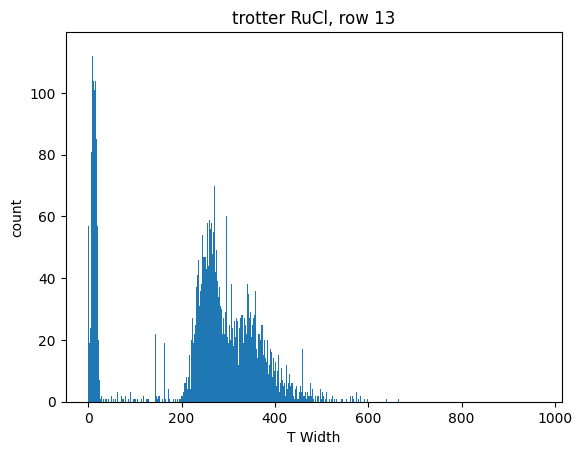

In [8]:
#Commenting out range, to avoid long runtimes.  This still takes ~20-30 minutes as written
for i in [13]:
#for i in range(19):
    #defining precision required for the trotterized circuit
    energy_precision = 1e-3
    figdir="Trotter/Figures/"
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    timesteps=1000
    H_rucl = generate_rucl_hamiltonian(32, df_rucl.iloc[i])
    H_rucl_pyliqtr = pyH(H_rucl)
    openfermion_hamiltonian_rucl = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_rucl_pyliqtr)
    
    print("Estimating RuCl row " + str(i) + " using Trotterization")
    t0 = time.perf_counter()
    cpt_trotter_rucl = estimate_trotter(openfermion_hamiltonian_rucl, timesteps, energy_precision, "Trotter/RuCl_circuits/", hamiltonian_name="rucl_" + str(i), write_circuits=True)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("Total time to estimate RuCl row " + str(i) + ": " + str(elapsed) + " seconds\n")
    
    plot_T_step_histogram(cpt_trotter_rucl)
    plt.title("trotter RuCl, row " + str(i))
    plt.xlabel("T Width")
    plt.ylabel("count")
    plt.savefig(figdir + "trotter_cpt_t_width_histogram_rucl_" + str(i) + ".pdf")

Estimating RuCl row 13 using QSP
  Time to generate high level QSP circuit: 251.30529584700707 seconds
    Time to decompose high level cirq.ops.pauli_gates._PauliX circuit: 0.0017888139700517058 seconds
    Time to transform decomposed cirq.ops.pauli_gates._PauliX circuit to Clifford+T: 0.0002529590856283903 seconds
    Time to decompose high level cirq.ops.common_gates.Rx circuit: 0.00037117197643965483 seconds
    Time to transform decomposed cirq.ops.common_gates.Rx circuit to Clifford+T: 0.031734484946355224 seconds
    Time to decompose high level pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit: 2.4821788049302995 seconds
    Time to transform decomposed pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit to Clifford+T: 824.4037302469369 seconds
    Time to decompose high level cirq.ops.common_gates.Ry circuit: 0.10492097598034889 seconds
    Time to transform decomposed cirq.ops.common_gates.Ry circuit to Clifford+T: 2.17835920

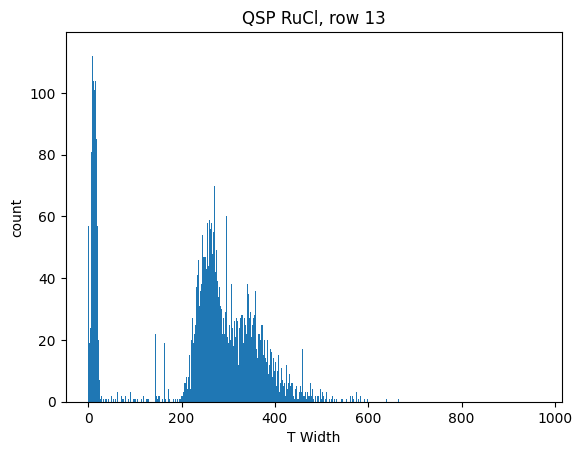

In [9]:
#Commenting out range, to avoid long runtimes.  This still takes ~20-30 minutes as written
for i in [13]:
#for i in range(19):
    #defining precision required for the trotterized circuit
    energy_precision = 1e-3
    figdir="QSP/Figures/"
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    timesteps=1000
    H_rucl = generate_rucl_hamiltonian(32, df_rucl.iloc[i])
    H_rucl_pyliqtr = pyH(H_rucl)
    
    print("Estimating RuCl row " + str(i) + " using QSP")
    t0 = time.perf_counter()
    #change to Clifford+T dictionary in future revision
    qsp_high_level_rucl = estimate_qsp(H_rucl_pyliqtr, timesteps, energy_precision, "QSP/RuCl_circuits/", hamiltonian_name="rucl_" + str(i))
    t1 = time.perf_counter()
    elapsed = t1 - t0
    print("Time to estimate RuCl row " + str(i) + ": " + str(elapsed) + " seconds\n")
    print()

In [10]:
t_end = time.perf_counter()
print("Total time to run notebook (only using the fastest row): " + str(t_end - t_init))

Total time to run notebook (only using the fastest row): 2518.8262146810303
